# Determine the per-event resolution model in B02JpsieeKS

### Einfacher Gauß reicht nicht aus, um die Auflösung zu beschreiben -> Doppelgauß ausprobieren
### -> Doppelgauß + wPV Komponente
### -> Dreifachgauß + wPV Komponente ...

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import ROOT
from ROOT import (RooArgSet,
                  RooCategory,
                  RooRealVar,
                  RooDataSet,
                  RooPlot,
                  RooFit,
                  RooStats,
                  RooArgList,
                  RooFormulaVar)

from ROOT import (TFile, 
                  TH1D, 
                  TH2D, 
                  TCanvas, 
                  gStyle, 
                  TLine, 
                  TTree)

import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from root_pandas import read_root
import pandas as pd
            
sys.path.append('/home/vmueller/repos/')
from dopy.doroot.root_utils import read_roodataset_from_tree, plot_pulls, build_tchain_from_files
from dopy.doplot.plotting import Plotter, Plot
import dopy.doroot.rootnotes 

In [2]:
#dataset_file_name = 'MCP68_bkgcat0.root'
mc_path = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/'
mc_file = 'Bd2JpsiKS_bestPV.root'

dataset_tree_name = 'Bd2JpsiKS'

dataset_file_name = os.path.join(mc_path, mc_file)

In [3]:
dataset_file = TFile(dataset_file_name)
dataset_tree = dataset_file.Get(dataset_tree_name)

In [4]:
obsTime     = RooRealVar('B0_FitPVConst_tau_flat', '#it{t}_{PV}', -4, 10, 'ns')
obsTimeErr  = RooRealVar('B0_FitPVConst_tauErr_flat', '#sigma(#it{t}_{PV})', 0, 0.0004, 'ns')
obsTimeTrue = RooRealVar('B0_TRUETAU', '#it{t}_{true}', 0.0, 10, 'ns')
cat_bin = RooCategory('cat_bin', 'cat_bin')

observables = RooArgSet(obsTime, obsTimeTrue, obsTimeErr)
data = RooDataSet("data", "data", dataset_tree, observables)

obsTime_ps = RooFormulaVar('obsTime_ps', '@0*1000', RooArgList(obsTime))
obsTime_ps = RooRealVar(data.addColumn(obsTime_ps))
obsTime_ps.setRange(-4000,11000)
obsTime_ps.SetTitle('#it{t}_{PV}')
obsTime_ps.setUnit('ps')
ROOT.SetOwnership(obsTime_ps, False)

obsTimeErr_ps = RooFormulaVar('obsTimeErr_ps', '@0*1000', RooArgList(obsTimeErr))
obsTimeErr_ps = RooRealVar(data.addColumn(obsTimeErr_ps))
#bsTimeErr_ps.setRange(1e-4,0.2)
obsTimeErr_ps.SetTitle('#sigma(#it{t}_{PV})')
obsTimeErr_ps.setUnit('ps')
ROOT.SetOwnership(obsTimeErr_ps, False)

obsTimeTrue_ps = RooFormulaVar('obsTimeTrue_ps', '@0*1000', RooArgList(obsTimeTrue))
obsTimeTrue_ps = RooRealVar(data.addColumn(obsTimeTrue_ps))
obsTimeTrue_ps.setRange(0,11000)
obsTimeTrue_ps.SetTitle('#it{t}_{PV}, true}')
obsTimeTrue_ps.setUnit('ps')

obsTimeResForm = RooFormulaVar('obsTimeResForm', '@0-@1', RooArgList(obsTime_ps, obsTimeTrue_ps))
obsTimeRes = RooRealVar(data.addColumn(obsTimeResForm))
obsTimeRes.setRange(-12,12)#-12,12
obsTimeRes.SetTitle('#it{t}_{PV}-#it{t}_{true}')
obsTimeRes.setUnit('ps')

#data = data.reduce('obsTimeResForm>-0.2&&obsTimeResForm<0.2&&obsTimeTrue_ps>0.0&&obsTimeTrue_ps<15&&obsTime_ps>0.0&&obsTime_ps<15.0')
  
#data = data.reduce('obsTimeResForm>-12&&obsTimeResForm<12')
 
print(data.numEntries())                                  

500415


In [5]:
subdir = '/home/chasenberg/plots/resolution'
plot_dir    = os.path.join(subdir, 'plots')
results_dir = os.path.join(subdir, 'results')
plot_file   = os.path.join(plot_dir, 'all_plots.pdf')

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [6]:
values = []
for i in range(data.numEntries()):
    values.append(data.get(i).getRealValue('obsTimeResForm'))
values

[-0.04771978436392699,
 0.03798291741168125,
 0.022414639954882354,
 0.019913004624871,
 0.3326969991422195,
 -0.08427435539532113,
 -0.01479112587025444,
 -0.02331675592392124,
 0.03056035858117334,
 -0.0029772193232814326,
 -0.023535633258462862,
 -0.04233376101237385,
 0.008612430465056387,
 -0.04404866622848802,
 -0.04446939637033931,
 0.026289558896727683,
 -0.03414708801111299,
 0.011250825232961503,
 0.009101581372434886,
 0.010132484787879648,
 0.016315376084293037,
 -0.03462350961928751,
 -0.04420571535355666,
 0.011845040007379515,
 0.025212956976055356,
 -0.01403432385514014,
 0.0230631822710905,
 0.05669065740444279,
 0.031887486439587054,
 0.055487184383079535,
 -0.04657297480686262,
 0.026205192459348714,
 0.00866754413392501,
 0.082975325217296,
 -0.054548889109666376,
 -0.10761589184180398,
 0.017528752252918167,
 0.04852270842080508,
 0.07931166761543396,
 -0.023927299875186103,
 -0.017268983291925,
 0.02665788156741744,
 0.025843127050127812,
 -0.058400428475381405,
 

In [7]:
num_bins = 20
values = []

for i in range(0,num_bins):
    cat_bin.defineType('bin'+str(i), i)

for i in range(data.numEntries()):
    values.append(data.get(i).getRealValue('obsTimeErr_ps'))
print(data.numEntries())
values_sorted = sorted(values)
length = len(values_sorted)
#print(length)

quantile = np.linspace(0, length-1, num_bins+1)
#print(len(quantile))

bins = [values_sorted[int(q)] for q in quantile]
#print(len(bins))

bins[0]  = obsTimeErr_ps.getMin() #min(values)
bins[-1] = obsTimeErr_ps.getMax() #max(values)

from array import array

500415


In [8]:
obsTimeErr_ps.getMax(),max(values)

(1e+30, 0.39416170329786837)

In [9]:
bins

[-1e+30,
 0.023866710762376897,
 0.02695800685614813,
 0.029209988497314043,
 0.031142499210545793,
 0.03289641972514801,
 0.03454554098425433,
 0.03617042602854781,
 0.03780466431635432,
 0.039443788409698755,
 0.041144889110000804,
 0.042941930587403476,
 0.04485859608394094,
 0.04693918162956834,
 0.0492815270263236,
 0.052016606787219644,
 0.05533696094062179,
 0.05969203994027339,
 0.06605168164242059,
 0.07771979289827868,
 1e+30]

In [10]:
from ROOT import RooGaussModel

def determine_var_in_bin(dataset, variable, bin_variable, bin_low, bin_high, index):
    data_set = dataset.reduce(bin_variable+'>='+str(bin_low)+'&&'+bin_variable+'<'+str(bin_high))
    cat_bin.setIndex(index)
    data_set.addColumn(cat_bin)
    ROOT.SetOwnership(data_set, False)
    print(bin_variable+'>'+str(bin_low)+'&&'+bin_variable+'<'+str(bin_high))
    print('num entries: '  + str(data_set.numEntries()), flush=True)
    values_res = []
    values_terr_sq = []
    
    for i in range(data_set.numEntries()):
        values_res.append(data_set.get(i).getRealValue(variable))
        values_terr_sq.append((data_set.get(i).getRealValue(bin_variable))**2)
        
    values_array_res = np.array(values_res)
    sigma_res = np.sqrt(values_array_res.var()) 
    sigma_sigma_res = np.sqrt((2*sigma_res**4)/(data_set.numEntries()-1))
    
    values_array_terr_sq = np.array(values_terr_sq)
    mean_terr_sq = np.sqrt(values_array_terr_sq.mean())
    
    parResMean  = RooRealVar('parResMean', 'parResMean', 0.0, -5.0, 5.0)
    parResSigma = RooRealVar('parResSigma', 'parResSigma', 0.06, 0.0, 1.0)
    pdfGaussModel = RooGaussModel('pdfGaussModel', 'pdfGaussModel', obsTimeRes, parResMean, parResSigma)
    
    parResSigma.setVal(sigma_res)
    parResMean.setVal(sigma_sigma_res)
    
    fit_result = pdfGaussModel.fitTo(data_set, 
                                    RooFit.NumCPU(6),
                                    RooFit.Minimizer('Minuit','minimize'),
                                    RooFit.Hesse(True),
                                    RooFit.Optimize(0),
                                    RooFit.PrintEvalErrors(0),
                                    RooFit.Save(True)) 
    
    fit_parResSigma = pdfGaussModel.getParameters(data_set).find('parResSigma')
    fit_parResMean = pdfGaussModel.getParameters(data_set).find('parResMean')
    
    print('INFO: Start plotting', flush=True)
    #sys.path.append('/home/vmueller/repos/root_utils')
    from ROOT import TColor
    from root_utils.lhcb_style import set_lhcb_style # Set basic LHCb plot style
    set_lhcb_style()   

    # Prepare frame
    canvas = TCanvas('canvas', 'canvas', 1000, 600)
    plot_frame = obsTimeRes.frame(ROOT.RooFit.Bins(100))
    data_set.plotOn(plot_frame, ROOT.RooFit.Name('data'))
    pdfGaussModel.plotOn(plot_frame, RooFit.LineColor(1))

    ### Add additional informations to the plot
    text_size = 0.035
    # Create TLegend
    legend = ROOT.TLegend(0.7, 0.75, 0.9, 0.9)
    legend.AddEntry(plot_frame.findObject('data'), 'Data', 'p')
    legend.SetTextSize(text_size)

    # Plot pulls
    plotname = 'plot'+str(bin_low)
    can, _ = plot_pulls(plotname, plot_frame, drawables=[legend], save_path= subdir + '/plots/', logy=True) 
    print('INFO: Finish plotting', flush=True)
    can
    
    return mean_terr_sq, sigma_res, sigma_sigma_res, fit_parResSigma, fit_parResMean, data_set

In [11]:
st_devs = []
st_dev_errors_fit = []
x_values = []
data_sets = []

for i in range(0,len(bins)-1):
    x_value, st_dev, st_dev_err, fit_sigma, fit_mean, data_set = determine_var_in_bin(data, 'obsTimeResForm', 'obsTimeErr_ps', bins[i], bins[i+1], i)
    print(i)
    print('x value: '  + str(x_value), flush=True)
    print('standard dev: '  + str(st_dev), flush=True)
    print('standard dev error: '  + str(st_dev_err), flush=True)
    print('fit_sigma: '  + str(fit_sigma.getValV()), flush=True)
    print('fit_sigma error: '  + str(fit_sigma.getError()), flush=True)
    print('fit_mean: '  + str(fit_mean.getValV()), flush=True)
    print('fit_mean error: '  + str(fit_mean.getError()), flush=True)
    x_values.append(x_value)
    st_devs.append(st_dev) 
    st_dev_errors_fit.append(fit_sigma.getError())
    data_sets.append(data_set)
    data_set.Print('v')

merged_dataset = RooDataSet(data_sets[0])
for data_set in data_sets[1:]:
    merged_dataset.append(data_set)
    
print(merged_dataset.numEntries())    

obsTimeErr_ps>-1e+30&&obsTimeErr_ps<0.023866710762376897
num entries: 25020
INFO: Start plotting
INFO: Finish plotting
0
x value: 0.0210022626142
standard dev: 0.0274891329662
standard dev error: 6.75619394833e-06
fit_sigma: 0.027489132966220686
fit_sigma error: 0.0
fit_mean: -2.3971217639008326
fit_mean error: 2.3971285200947814
obsTimeErr_ps>0.023866710762376897&&obsTimeErr_ps<0.02695800685614813
num entries: 25021
INFO: Start plotting
INFO: Finish plotting
1
x value: 0.0255296973108
standard dev: 0.0288280324957
standard dev error: 7.43021449323e-06
fit_sigma: 0.02882806260544485
fit_sigma error: 0.00012886905494999268
fit_mean: 4.012639106765192e-05
fit_mean error: 0.00018224817160161777
obsTimeErr_ps>0.02695800685614813&&obsTimeErr_ps<0.029209988497314043
num entries: 25021


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Start plotting
INFO: Finish plotting
2
x value: 0.0281248875874
standard dev: 0.0315945244517
standard dev error: 8.92472804218e-06
fit_sigma: 0.031594571215196654
fit_sigma error: 0.00014123618443107055
fit_mean: 5.569514562431266e-05
fit_mean error: 0.00019973776540238575
obsTimeErr_ps>0.029209988497314043&&obsTimeErr_ps<0.031142499210545793
num entries: 25020


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Start plotting
INFO: Finish plotting
3
x value: 0.0302000326358
standard dev: 0.0356876966978
standard dev error: 1.13872029978e-05
fit_sigma: 0.035687696697773386
fit_sigma error: 0.0
fit_mean: -2.3971176998040193
fit_mean error: 2.3971290870070163
obsTimeErr_ps>0.031142499210545793&&obsTimeErr_ps<0.03289641972514801
num entries: 25021


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Start plotting
INFO: Finish plotting
4
x value: 0.0320301706751
standard dev: 0.099834212597
standard dev error: 8.91107582378e-05
fit_sigma: 0.09983421259698366
fit_sigma error: 0.0
fit_mean: -2.39704949059281
fit_mean error: 2.3971386013510476
obsTimeErr_ps>0.03289641972514801&&obsTimeErr_ps<0.03454554098425433
num entries: 25021


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Start plotting
INFO: Finish plotting
5
x value: 0.0337311539274
standard dev: 0.0407165125933
standard dev error: 1.4822193943e-05
fit_sigma: 0.040716512593304555
fit_sigma error: 0.0
fit_mean: -2.397114685311549
fit_mean error: 2.3971295075054924
obsTimeErr_ps>0.03454554098425433&&obsTimeErr_ps<0.03617042602854781
num entries: 25020


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Start plotting
INFO: Finish plotting
6
x value: 0.0353606055091
standard dev: 0.0708989849996
standard dev error: 4.49427931486e-05
fit_sigma: 0.07089898499960956
fit_sigma error: 0.0
fit_mean: -2.3970882519126286
fit_mean error: 2.3971331947057766
obsTimeErr_ps>0.03617042602854781&&obsTimeErr_ps<0.03780466431635432
num entries: 25021


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Start plotting
INFO: Finish plotting
7
x value: 0.0369879561012
standard dev: 0.0450987805667
standard dev error: 1.8184482376e-05
fit_sigma: 0.045098780566733
fit_sigma error: 0.0
fit_mean: -2.3971117346205317
fit_mean error: 2.397129919102907
obsTimeErr_ps>0.03780466431635432&&obsTimeErr_ps<0.039443788409698755
num entries: 25021


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Start plotting
INFO: Finish plotting
8
x value: 0.0386182610323
standard dev: 0.101095101127
standard dev error: 9.13758788926e-05
fit_sigma: 0.10109510112734665
fit_sigma error: 0.25366530722379843
fit_mean: -2.397047502742823
fit_mean error: 4.207354923336892
obsTimeErr_ps>0.039443788409698755&&obsTimeErr_ps<0.041144889110000804
num entries: 25021


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Start plotting
INFO: Finish plotting
9
x value: 0.040291304803
standard dev: 0.0616202683941
standard dev error: 3.39483379115e-05
fit_sigma: 0.061620268394132593
fit_sigma error: 0.0
fit_mean: -2.397097900496405
fit_mean error: 2.397131848834317
obsTimeErr_ps>0.041144889110000804&&obsTimeErr_ps<0.042941930587403476
num entries: 25020


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Start plotting
INFO: Finish plotting
10
x value: 0.0420319999795
standard dev: 0.0757244008982
standard dev error: 5.12686304714e-05
fit_sigma: 0.07572440089816046
fit_sigma error: 0.0
fit_mean: -2.397082700438925
fit_mean error: 2.397133969069397
obsTimeErr_ps>0.042941930587403476&&obsTimeErr_ps<0.04485859608394094
num entries: 25021


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Start plotting
INFO: Finish plotting
11
x value: 0.0438893554827
standard dev: 0.0746262840517
standard dev error: 4.97914735165e-05
fit_sigma: 0.07462628405166483
fit_sigma error: 0.0
fit_mean: -2.397083996773267
fit_mean error: 2.397133788246783
obsTimeErr_ps>0.04485859608394094&&obsTimeErr_ps<0.04693918162956834
num entries: 25021


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Start plotting
INFO: Finish plotting
12
x value: 0.0458838475436
standard dev: 0.0676228788892
standard dev error: 4.08844968087e-05
fit_sigma: 0.06762287888915042
fit_sigma error: 0.0
fit_mean: -2.3970918134194266
fit_mean error: 2.3971326979162346
obsTimeErr_ps>0.04693918162956834&&obsTimeErr_ps<0.0492815270263236
num entries: 25019


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Start plotting
INFO: Finish plotting
13
x value: 0.0480856391474
standard dev: 0.141354551226
standard dev error: 0.000178652170112
fit_sigma: 0.14135455122555557
fit_sigma error: 0.0
fit_mean: -2.3969709094617175
fit_mean error: 2.3971495616318297
obsTimeErr_ps>0.0492815270263236&&obsTimeErr_ps<0.052016606787219644
num entries: 25022


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Start plotting
INFO: Finish plotting
14
x value: 0.0506242666896
standard dev: 0.17441938116
standard dev error: 0.000271989506433
fit_sigma: 0.17441938115973943
fit_sigma error: 0.0
fit_mean: -2.396888996226443
fit_mean error: 2.397160985732877
obsTimeErr_ps>0.052016606787219644&&obsTimeErr_ps<0.05533696094062179
num entries: 25021


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Start plotting
INFO: Finish plotting
15
x value: 0.0536205721515
standard dev: 0.200782027725
standard dev error: 0.000360430070664
fit_sigma: 0.2007820277248158
fit_sigma error: 0.3370809305133644
fit_mean: -2.39681137964801
fit_mean error: 4.207354913107947


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


obsTimeErr_ps>0.05533696094062179&&obsTimeErr_ps<0.05969203994027339
num entries: 25020
INFO: Start plotting
INFO: Finish plotting
16
x value: 0.0574077507405
standard dev: 0.106604223724
standard dev error: 0.000101608221174
fit_sigma: 0.10660422372432365
fit_sigma error: 0.0
fit_mean: -2.3970385229229985
fit_mean error: 2.397140131144172
obsTimeErr_ps>0.05969203994027339&&obsTimeErr_ps<0.06605168164242059
num entries: 25021


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Start plotting
INFO: Finish plotting
17
x value: 0.0626632522342
standard dev: 0.414629274058
standard dev error: 0.00153706158215
fit_sigma: 0.414629274057718
fit_sigma error: 0.41455735622936907
fit_mean: -2.395778681312888
fit_mean error: 4.207354725237051
obsTimeErr_ps>0.06605168164242059&&obsTimeErr_ps<0.07771979289827868
num entries: 25021


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Start plotting
INFO: Finish plotting
18
x value: 0.0712102986842
standard dev: 0.484820824452
standard dev error: 0.00210152168958
fit_sigma: 0.484820824451988
fit_sigma error: 0.4205415665949048
fit_mean: -2.395283222499619
fit_mean error: 4.207354552412774
obsTimeErr_ps>0.07771979289827868&&obsTimeErr_ps<1e+30
num entries: 25022


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Start plotting
INFO: Finish plotting
19
x value: 0.0997544507097
standard dev: 1.2476828374
standard dev error: 0.013917815297
fit_sigma: 0.9999990463259867
fit_sigma error: 0.2298484086641852
fit_mean: -2.3849043742584595
fit_mean error: 4.207338624245171


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


500415


In [12]:
#print(len(data_sets))
#num = 0
#for i in data_sets:
#    num = num + i.numEntries()
#    print(i.numEntries())
#    i.Print('v')
#    
#print(num)    

In [13]:
from ROOT import RooSimultaneous, RooExtendPdf, RooAddModel

data_model = RooSimultaneous('data_model', 'data_model', cat_bin)
ROOT.SetOwnership(data_model, False)




for i in range(num_bins):
    parResMean  = RooRealVar('parResMean', 'parResMean', 0.0, -5.0, 5.0)
    ROOT.SetOwnership(parResMean, False)
    
    parResSigma_wpv = RooRealVar('parResSigma_wpv', 'parResSigma_wpv', 3.5, 0.5, 10.0)
    ROOT.SetOwnership(parResSigma_wpv, False)

    parResSigma_narrow = RooRealVar('parResSigma_narrow'+str(i), 'parResSigma_narrow'+str(i), 2.9e-05, 0.0, 0.03)
    ROOT.SetOwnership(parResSigma_narrow, False)
    parResSigma_mid = RooRealVar('parResSigma_mid'+str(i), 'parResSigma_mid'+str(i), 0.00014, 0.04, 0.1)
    ROOT.SetOwnership(parResSigma_mid, False)
    parResSigma_wide = RooRealVar('parResSigma_wide'+str(i), 'parResSigma_wide'+str(i), 0.025, 0.15, 2.0)
    ROOT.SetOwnership(parResSigma_wide, False)
    
    parResFrac_wide = RooRealVar('parResFrac_wide', 'parResFrac_wide', 0.6, 0.5, 1.0) #0.6, 0.1, 1.0
    ROOT.SetOwnership(parResFrac_wide, False)
    parResFrac_wpv = RooRealVar('parResFrac_wpv', 'parResFrac_wpv', 0.0009, 0.0, 0.1)
    ROOT.SetOwnership(parResFrac_wpv, False)
    #parResCoeff_first = RooFormulaVar('parResCoeff_first', '(1-@0)*@1', RooArgList(parResFrac_narrow, parResFrac_wide))
    #ROOT.SetOwnership(parResCoeff_first, False)
    #parResCoeff_second = RooFormulaVar('parResCoeff_second', '(1-@0)*(1-@1)', RooArgList(parResFrac_narrow, parResFrac_wide))
    #ROOT.SetOwnership(parResCoeff_second, False)
    
    pdfGaussModel_narrow = RooGaussModel('pdfGaussModel_narrow'+str(i), 'pdfGaussModel_narrow'+str(i), obsTimeRes, parResMean, parResSigma_narrow)
    ROOT.SetOwnership(pdfGaussModel_narrow, False)
    
    #pdfGaussModel_mid = RooGaussModel('pdfGaussModel_mid'+str(i), 'pdfGaussModel_mid'+str(i), obsTimeRes, parResMean, parResSigma_mid)
    #ROOT.SetOwnership(pdfGaussModel_mid, False)
    
    pdfGaussModel_wide = RooGaussModel('pdfGaussModel_wide'+str(i), 'pdfGaussModel_wide'+str(i), obsTimeRes, parResMean, parResSigma_wide)
    ROOT.SetOwnership(pdfGaussModel_wide, False)
    
    pdfGaussModel_wpv = RooGaussModel('pdfGaussModel_wpv'+str(i), 'pdfGaussModel_wpv'+str(i), obsTimeRes, parResMean, parResSigma_wpv)
    ROOT.SetOwnership(pdfGaussModel_wpv, False)
    
    #including wpv component -> 4 Gaussians
    #pdfGaussModel_sum = RooAddModel('pdfGaussModel_sum'+str(i), 'pdfGaussModel_sum'+str(i), RooArgList(pdfGaussModel_wpv, pdfGaussModel_wide, pdfGaussModel_mid, pdfGaussModel_narrow), RooArgList(parResFrac_wpv, parResFrac_wide, parResFrac_mid))
    #ROOT.SetOwnership(pdfGaussModel_sum, False)
    
    # including wpv component -> 3 Gaussians
    pdfGaussModel_sum = RooAddModel('pdfGaussModel_sum'+str(i), 'pdfGaussModel_sum'+str(i), RooArgList(pdfGaussModel_wpv, pdfGaussModel_wide, pdfGaussModel_narrow), RooArgList(parResFrac_wpv, parResFrac_wide))
    ROOT.SetOwnership(pdfGaussModel_sum, False)
    
    # excluding wpv component -> 2 Gaussians
    #pdfGaussModel_sum = RooAddModel('pdfGaussModel_sum'+str(i), 'pdfGaussModel_sum'+str(i), RooArgList(pdfGaussModel_wpv, pdfGaussModel_narrow), RooArgList(parResFrac_wpv))
    #ROOT.SetOwnership(pdfGaussModel_sum, False)
    
    #if i >13:
    #    parResSigma_narrow.setVal(0.3)
    #    parResSigma_wide.setVal(0.3)
    
    #if i<=10:
    #    data_model.addPdf(pdfGaussModel_sum, 'bin'+str(i))
    
    data_model.addPdf(pdfGaussModel_sum, 'bin'+str(i))
    
data_model.Print('v')    

In [14]:
parameters_file_name  = 'params.txt';
parameters_init_name  = parameters_file_name.replace('.txt', '_init.txt')
parameters_final_name = parameters_file_name.replace('.txt', '_final.txt')

if os.path.exists(os.path.join(results_dir, parameters_init_name)):
    print('INFO: Reading parameters from configfile '  + os.path.join(results_dir, parameters_init_name), flush=True)
    data_model.getParameters(merged_dataset).readFromFile(os.path.join(results_dir, parameters_init_name))
else:
    print('INFO: configfile... '  + os.path.join(results_dir, parameters_init_name) + ' does not exist', flush=True)
    
fit_result = data_model.fitTo(merged_dataset, 
                                    RooFit.NumCPU(6),
                                    RooFit.Minimizer('Minuit','minimize'),
                                    RooFit.Hesse(True),
                                    RooFit.Save(True))

if fit_result:
    fit_result.Print('v')
    fit_result.correlationMatrix().Print('v')
    if fit_result.status()==0:
        print('INFO: Fit converged')
    else:
        print('INFO: Status '+str(fit_result.status()))
    print('INFO: Fit complete', flush=True)
else:
    print('ERROR: There is no fitresult', flush=True)
 
final_params_file = os.path.join(results_dir, parameters_final_name)
data_model.getParameters(merged_dataset).writeToFile(final_params_file)

INFO: configfile... /home/chasenberg/plots/resolution/results/params_init.txt does not exist
INFO: Fit converged
INFO: Fit complete


In [15]:
data_model.Print('v')
print(data_model.getComponents().find('pdfGaussModel_sum0').coefList().Print('v'))

None


In [16]:
def plot(data, pdf, x_min, x_max, logy=False, legendtitle ='', sliceargs=None, plotname='plot'):
    obsTimeRes.setRange(x_min, x_max)
    frame = obsTimeRes.frame(RooFit.Range(x_min, x_max))#-0.4, 0.4
    legend = ROOT.TLegend(0.60, 0.75, 0.9, 0.85)
    
    set_narrow = ROOT.RooArgSet()
    ROOT.SetOwnership(set_narrow, False)
    set_mid = ROOT.RooArgSet()
    ROOT.SetOwnership(set_mid, False)
    set_wide = ROOT.RooArgSet()
    ROOT.SetOwnership(set_wide, False)
    set_wpv = ROOT.RooArgSet()
    ROOT.SetOwnership(set_wpv, False)
    
    catlabel = ''
    
    if sliceargs:
        obs_iter = sliceargs.createIterator()
        cutstring = ""
        while(True):
            obj = obs_iter.Next()
            singlecut = ""
            if not obj:
                break
            else:
                catname = obj.GetName()
                catlabel = obj.getLabel()
                singlecut = catname + "==" + catname + "::" + catlabel
            if cutstring:
                cutstring += " && " + singlecut
            else:
                cutstring = singlecut
                
        print("Dataset will be cut: " + cutstring)
        data_for_proj = data.reduce(cutstring)
        data_for_proj.plotOn(frame)
        
        set_narrow.add(pdf.getComponents().find('pdfGaussModel_narrow'+catlabel.strip( 'bin' )))
        #set_mid.add(pdf.getComponents().find('pdfGaussModel_mid'+catlabel.strip( 'bin' )))
        set_wide.add(pdf.getComponents().find('pdfGaussModel_wide'+catlabel.strip( 'bin' )))
        set_wpv.add(pdf.getComponents().find('pdfGaussModel_wpv'+catlabel.strip( 'bin' )))
        
        pdf.plotOn(frame,
                   RooFit.ProjWData(data_for_proj),
                   RooFit.Slice(sliceargs),
                   RooFit.LineColor(1),
                   RooFit.Name("pdf"))
        
        pdf.plotOn(frame,
                   RooFit.Components(set_narrow),
                   RooFit.LineStyle(2),
                   RooFit.LineColor(226),
                   RooFit.ProjWData(data_for_proj),
                   RooFit.Slice(sliceargs),
                   RooFit.Name("pdfGaussModel_narrow"))
        
        #pdf.plotOn(frame,
        #           RooFit.Components(set_mid),
        #           RooFit.LineStyle(2),
        #           RooFit.LineColor(610),
        #           RooFit.ProjWData(data_for_proj),
        #           RooFit.Slice(sliceargs),
        #           RooFit.Name("pdfGaussModel_mid"))
        
        pdf.plotOn(frame,
                   RooFit.Components(set_wide),
                   RooFit.LineStyle(3),
                   RooFit.LineColor(410),
                   RooFit.ProjWData(data_for_proj),
                   RooFit.Slice(sliceargs),
                   RooFit.Name("pdfGaussModel_wide"))
        
        pdf.plotOn(frame,
                   RooFit.Components(set_wpv),
                   RooFit.LineStyle(8),
                   RooFit.LineColor(96),
                   RooFit.ProjWData(data_for_proj),
                   RooFit.Slice(sliceargs),
                   RooFit.Name("pdfGaussModel_wpv"))
        
        pdf.plotOn(frame,
                   RooFit.ProjWData(data_for_proj),
                   RooFit.Slice(sliceargs),
                   RooFit.LineColor(1),
                   RooFit.Name("pdf"))
        
        legend.AddEntry(frame.findObject("pdf"), legendtitle, 'l')
        legend.AddEntry(frame.findObject("pdfGaussModel_narrow"), 'pdfGaussModel_narrow', 'l')
        #legend.AddEntry(frame.findObject("pdfGaussModel_mid"), 'pdfGaussModel_mid', 'l')
        legend.AddEntry(frame.findObject("pdfGaussModel_wide"), 'pdfGaussModel_wide', 'l')
        legend.AddEntry(frame.findObject("pdfGaussModel_wpv"), 'pdfGaussModel_wpv', 'l')
        
    else:
        cut = 'obsTimeResForm>'+str(x_min)+'&&'+'obsTimeResForm<'+str(x_max)
        #print(cut)
        data_for_plot = data.reduce(cut)
        data_for_plot.plotOn(frame)
        pdf.plotOn(frame,
                   RooFit.ProjWData(RooArgSet(cat_bin), data_for_plot, True),
                   RooFit.NumCPU(1),
                   RooFit.LineColor(1),
                   RooFit.Name("pdf"))
        legend.AddEntry(frame.findObject("pdf"), legendtitle, 'l')
    
    frame.Draw()
    text_size = 0.035
    legend.SetTextSize(text_size)
    ROOT.SetOwnership(legend, False)
    
    plotname += catlabel
    
    can, _ = plot_pulls(plotname, frame, drawables=[legend], save_path=subdir + '/plots/', appendices=['.pdf', '.png'], logy=True)
    return can

In [17]:
for i in range(0,20):
    cat_bin.setLabel('bin'+str(i))
    plot(merged_dataset, data_model, -0.5, 0.5, sliceargs=RooArgSet(cat_bin))

Dataset will be cut: cat_bin==cat_bin::bin0


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


Dataset will be cut: cat_bin==cat_bin::bin1


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


Dataset will be cut: cat_bin==cat_bin::bin2


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


Dataset will be cut: cat_bin==cat_bin::bin3


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


Dataset will be cut: cat_bin==cat_bin::bin4


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


Dataset will be cut: cat_bin==cat_bin::bin5


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


Dataset will be cut: cat_bin==cat_bin::bin6


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


Dataset will be cut: cat_bin==cat_bin::bin7


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


Dataset will be cut: cat_bin==cat_bin::bin8


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


Dataset will be cut: cat_bin==cat_bin::bin9


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


Dataset will be cut: cat_bin==cat_bin::bin10


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


Dataset will be cut: cat_bin==cat_bin::bin11


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


Dataset will be cut: cat_bin==cat_bin::bin12
Dataset will be cut: cat_bin==cat_bin::bin13


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


Dataset will be cut: cat_bin==cat_bin::bin14


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


Dataset will be cut: cat_bin==cat_bin::bin15
Dataset will be cut: cat_bin==cat_bin::bin16


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


Dataset will be cut: cat_bin==cat_bin::bin17


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


Dataset will be cut: cat_bin==cat_bin::bin18


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


Dataset will be cut: cat_bin==cat_bin::bin19


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


In [18]:
merged_dataset.numEntries()

500415

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


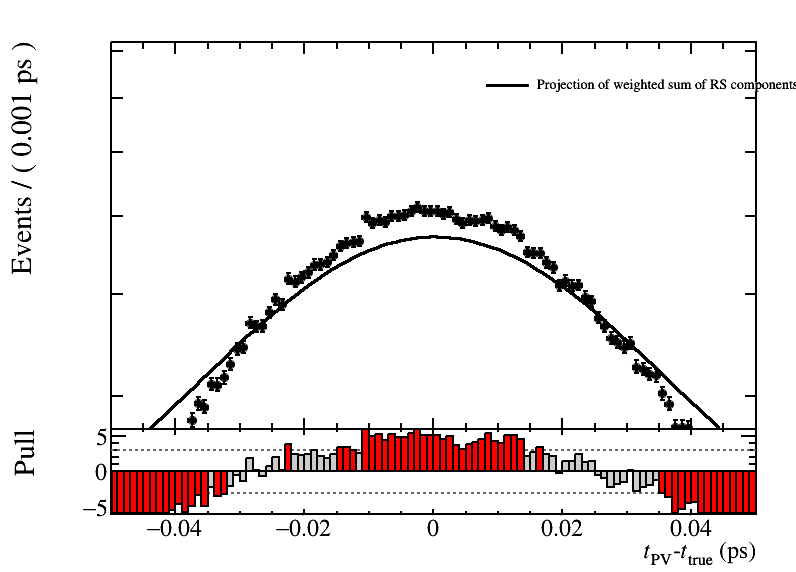

In [19]:
plot(merged_dataset, data_model, -0.05, 0.05)

In [20]:
y_narrow = {}
y_mid    = {}
y_wide   = {}
y_frac   = {}

In [21]:
import collections

iter = data_model.getParameters(merged_dataset).createIterator()
var = iter.Next()
while var:
    #print(var.GetName())
    if 'Sigma_wide' in var.GetName():
        #print('Save value and error of {} to list'.format(var.GetName()), flush=True)
        y_wide[var.GetName().strip( 'parResSigma_wide' )] = [var.getValV(),var.getError()]
    if 'Sigma_mid' in var.GetName():
        #print('Save value and error of {} to list'.format(var.GetName()), flush=True)
        y_mid[var.GetName().strip( 'parResSigma_mid' )] = [var.getValV(),var.getError()]
    if 'Sigma_narrow' in var.GetName():
        #print('Save value and error of {} to list'.format(var.GetName()), flush=True)
        y_narrow[var.GetName().strip( 'parResSigma_narrow' )] = [var.getValV(),var.getError()] 
    if 'parResFrac_wide' in var.GetName():
        #print('Save value and error of {} to list'.format(var.GetName()), flush=True)
        y_frac[var.GetName().strip( 'parResFrac_wide' )] = [var.getValV(),var.getError()]      
    var=iter.Next()
    
def get_key(key):
    try:
        return int(key)
    except ValueError:
        return key
    
y_narrow_od = collections.OrderedDict(sorted(y_narrow.items(), key=lambda t: get_key(t[0])))
y_mid_od = collections.OrderedDict(sorted(y_mid.items(), key=lambda t: get_key(t[0])))
y_wide_od = collections.OrderedDict(sorted(y_wide.items(), key=lambda t: get_key(t[0])))
y_frac_od = collections.OrderedDict(sorted(y_frac.items(), key=lambda t: get_key(t[0])))
    
#y_narrow_od = collections.OrderedDict(sorted(y_narrow.items()))    
#y_wide_od = collections.OrderedDict(sorted(y_wide.items()))   

In [22]:
#y_mid_od

In [23]:
y_values_narrow, y_errors_narrow = [v[0] for v in y_narrow_od.values()], [v[1] for v in y_narrow_od.values()]
y_values_mid, y_errors_mid = [v[0] for v in y_mid_od.values()], [v[1] for v in y_mid_od.values()]
y_values_wide, y_errors_wide = [v[0] for v in y_wide_od.values()], [v[1] for v in y_wide_od.values()]
y_values_frac, y_errors_frac = [v[0] for v in y_frac_od.values()], [v[1] for v in y_frac_od.values()]

In [24]:
#y_values_mid

In [25]:
#x_values

In [26]:
#plt.errorbar(x_values, y_values_frac, xerr=0, yerr=y_errors_frac, marker='o', color='r', ls='')

<Container object of 3 artists>

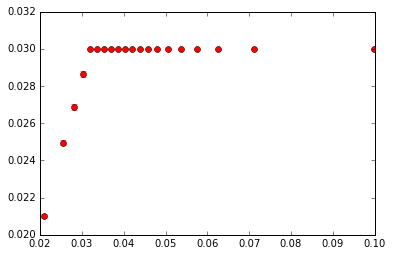

In [27]:
plt.errorbar(x_values, y_values_narrow, xerr=0, yerr=y_errors_narrow, marker='o', color='r', ls='')

In [28]:
#plt.errorbar(x_values, y_values_mid, xerr=0, yerr=y_errors_mid, marker='o', color='r', ls='')

<Container object of 3 artists>

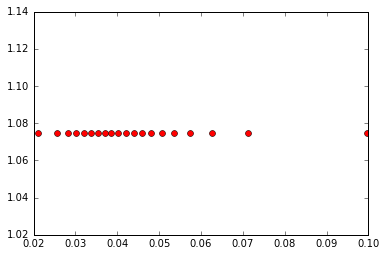

In [29]:
plt.errorbar(x_values, y_values_wide, xerr=0, yerr=y_errors_wide, marker='o', color='r', ls='')

### Narrow Gaussian

In [30]:
from scipy.optimize import curve_fit

def line(x, a, b):
    return a * x + b

def parabel(x, a, b, c):
    return c * x * x + a * x + b

In [31]:
popt, pcov = curve_fit(line, x_values, y_values_narrow, sigma=y_errors_narrow)

In [32]:
#popt

In [33]:
#pcov

In [34]:
print("a =", popt[0], "+/-", pcov[0,0]**0.5)
print("b =", popt[1], "+/-", pcov[1,1]**0.5)

a = 1.39236194761e-05 +/- 0.000372123731498
b = 0.0299990117939 +/- 2.4175411721e-05


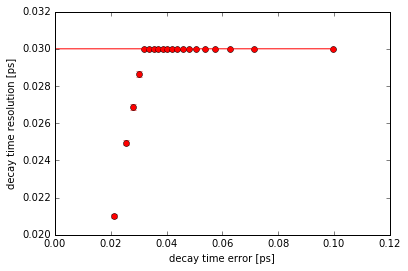

In [35]:
plt.errorbar(x_values, y_values_narrow, xerr=0, yerr=y_errors_narrow, marker='o', color='r', ls='')
xfine = np.linspace(0., 0.1, 20)  # define values to plot the function for
fig = plt.plot(xfine, line(xfine, popt[0], popt[1]), 'r-')
plt.xlabel('decay time error [ps]')
plt.ylabel('decay time resolution [ps]')
#plt.show()
plt.savefig(subdir + '/plots/narrow_gaussian.pdf')

### Wide Gaussian

In [36]:
popt, pcov = curve_fit(line, x_values, y_values_wide, sigma=y_errors_wide)

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/scipy/optimize/minpack.py:666: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1.0 / asarray(sigma) if sigma is not None else None
/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [37]:
print("a =", popt[0], "+/-", pcov[0,0]**0.5)
print("b =", popt[1], "+/-", pcov[1,1]**0.5)

a = 1.0 +/- inf
b = 1.0 +/- inf


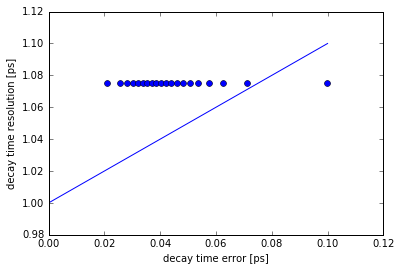

In [38]:
plt.errorbar(x_values, y_values_wide, xerr=0, yerr=y_errors_wide, marker='o', color='b', ls='')
xfine = np.linspace(0., 0.1, 20)  # define values to plot the function for
fig = plt.plot(xfine, line(xfine, popt[0], popt[1]), 'b-')
plt.xlabel('decay time error [ps]')
plt.ylabel('decay time resolution [ps]')
#plt.show()
plt.savefig(subdir + '/plots/wide_gaussian.pdf')

In [39]:
popt_p, pcov_p = curve_fit(parabel, x_values, y_values_wide, sigma=y_errors_wide)

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/scipy/optimize/minpack.py:666: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1.0 / asarray(sigma) if sigma is not None else None
/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [40]:
print("a =", popt_p[0], "+/-", pcov_p[0,0]**0.5)
print("b =", popt_p[1], "+/-", pcov_p[1,1]**0.5)
print("c =", popt_p[2], "+/-", pcov_p[2,2]**0.5)

a = 1.0 +/- inf
b = 1.0 +/- inf
c = 1.0 +/- inf


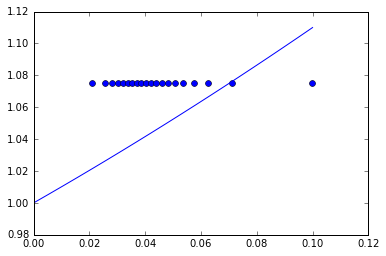

In [41]:
plt.errorbar(x_values, y_values_wide, xerr=0, yerr=y_errors_wide, marker='o', color='b', ls='')
xfine = np.linspace(0., 0.1, 20)  # define values to plot the function for
plt.plot(xfine, parabel(xfine, popt_p[0], popt_p[1], popt_p[2]), 'b-')

### Mid Gaussian

In [42]:
popt, pcov = curve_fit(line, x_values, y_values_mid, sigma=y_errors_mid)

ValueError: operands could not be broadcast together with shapes (20,) (0,) 

In [ ]:
print("a =", popt[0], "+/-", pcov[0,0]**0.5)
print("b =", popt[1], "+/-", pcov[1,1]**0.5)

In [ ]:
plt.errorbar(x_values, y_values_mid, xerr=0, yerr=y_errors_mid, marker='o', color='r', ls='')
xfine = np.linspace(0., 0.1, 20)  # define values to plot the function for
plt.plot(xfine, line(xfine, popt[0], popt[1]), 'r-')

# Conditional PDF

In [ ]:
obsTimeResForm.setRange(-12,12)

from ROOT import RooGaussian, RooAddPdf

parResCondMean  = RooRealVar('parResCondMean', 'parResCondMean', 0.0, -5.0, 5.0)
ROOT.SetOwnership(parResCondMean, False)

parResCond_a_narrow = RooRealVar('parResCond_a_narrow', 'parResCond_a_narrow', 1.0, 0.0001, 5)
ROOT.SetOwnership(parResCond_a_narrow, False)
parResCond_b_narrow = RooRealVar('parResCond_b_narrow', 'parResCond_b_narrow', 0.02, 0.0001, 0.5)
ROOT.SetOwnership(parResCond_b_narrow, False)

parResCond_a_wide = RooRealVar('parResCond_a_wide', 'parResCond_a_wide', 1.0, 0.0001, 5)
ROOT.SetOwnership(parResCond_a_wide, False)
parResCond_b_wide = RooRealVar('parResCond_b_wide', 'parResCond_b_wide', 0.02, 0.0001, 0.5)
ROOT.SetOwnership(parResCond_b_wide, False)
parResCond_c_wide = RooRealVar('parResCond_c_wide', 'parResCond_c_wide', 0.02, 0.0001, 0.5)
ROOT.SetOwnership(parResCond_c_wide, False)

parResCond_a_mid = RooRealVar('parResCond_a_mid', 'parResCond_a_mid', 1.0, 0.0001, 5)
ROOT.SetOwnership(parResCond_a_mid, False)
parResCond_b_mid = RooRealVar('parResCond_b_mid', 'parResCond_b_mid', 0.02, 0.0001, 0.5)
ROOT.SetOwnership(parResCond_b_mid, False)

parResCondSigma_narrow = RooFormulaVar('parResCondSigma_narrow', '@0*@1+@2', RooArgList(parResCond_a_narrow, obsTimeErr_ps, parResCond_b_narrow))
ROOT.SetOwnership(parResCondSigma_narrow, False)
#parResCondSigma_wide = RooFormulaVar('parResCondSigma_wide', '@3*@1*@1+@0*@1+@2', RooArgList(parResCond_a_wide, obsTimeErr_ps, parResCond_b_wide, parResCond_c_wide))
#ROOT.SetOwnership(parResCondSigma_wide, False)
parResCondSigma_wide = RooFormulaVar('parResCondSigma_wide', '@0*@1+@2', RooArgList(parResCond_a_wide, obsTimeErr_ps, parResCond_b_wide))
ROOT.SetOwnership(parResCondSigma_wide, False)

parResCondSigma_mid = RooFormulaVar('parResCondSigma_mid', '@0*@1+@2', RooArgList(parResCond_a_mid, obsTimeErr_ps, parResCond_b_mid))
ROOT.SetOwnership(parResCondSigma_mid, False)

parResCondSigma_wpv = RooRealVar('parResCondSigma_wpv', 'parResCondSigma_wpv', 2.53, 0.005, 100.0)
ROOT.SetOwnership(parResCondSigma_wpv, False)

parResCondFrac_wpv = RooRealVar('parResCondFrac_wpv', 'parResCondFrac_wpv', 0.1, 0.0, 1.0)
ROOT.SetOwnership(parResCondFrac_wpv, False)
parResCondFrac_mid = RooRealVar('parResCondFrac_mid', 'parResCondFrac_mid', 0.16, 0.05, 0.3)
ROOT.SetOwnership(parResCondFrac_mid, False)
parResCondFrac_wide = RooRealVar('parResCondFrac_wide', 'parResCondFrac_wide', 0.0016, 0.01, 1.0)
ROOT.SetOwnership(parResCondFrac_wide, False)

    
pdfGaussianCond_narrow = RooGaussian('pdfGaussianCond_narrow', 'pdfGaussianCond_narrow', obsTimeResForm, parResCondMean, parResCondSigma_narrow)
ROOT.SetOwnership(pdfGaussianCond_narrow, False)

pdfGaussianCond_mid = RooGaussian('pdfGaussianCond_mid', 'pdfGaussianCond_mid', obsTimeResForm, parResCondMean, parResCondSigma_mid)
ROOT.SetOwnership(pdfGaussianCond_mid, False)
    
pdfGaussianCond_wide = RooGaussian('pdfGaussianCond_wide', 'pdfGaussianCond_wide', obsTimeResForm, parResCondMean, parResCondSigma_wide)
ROOT.SetOwnership(pdfGaussianCond_wide, False)
    
pdfGaussianCond_wpv = RooGaussian('pdfGaussianCond_wpv', 'pdfGaussianCond_wpv', obsTimeResForm, parResCondMean, parResCondSigma_wpv)
ROOT.SetOwnership(pdfGaussianCond_wpv, False)
    
# including wpv component -> 3 Gaussians
pdfGaussianCond_sum = RooAddPdf('pdfGaussianCond_sum', 'pdfGaussianCond_sum', RooArgList(pdfGaussianCond_wpv, pdfGaussianCond_wide, pdfGaussianCond_narrow), RooArgList(parResCondFrac_wpv, parResCondFrac_wide))
ROOT.SetOwnership(pdfGaussianCond_sum, False)

#pdfGaussianCond_sum = RooAddPdf('pdfGaussianCond_sum', 'pdfGaussianCond_sum', RooArgList(pdfGaussianCond_wpv, pdfGaussianCond_wide, pdfGaussianCond_mid, pdfGaussianCond_narrow), RooArgList(parResCondFrac_wpv, parResCondFrac_wide, parResCondFrac_mid))
#ROOT.SetOwnership(pdfGaussianCond_sum, False) 

data_model_cond = pdfGaussianCond_sum
data_model_cond.Print('v')

In [ ]:
parameters_file_name  = 'params_cond_4.txt';
parameters_init_name  = parameters_file_name.replace('.txt', '_init.txt')
parameters_final_name = parameters_file_name.replace('.txt', '_final.txt')

if os.path.exists(os.path.join(results_dir, parameters_init_name)):
    print('INFO: Reading parameters from configfile '  + os.path.join(results_dir, parameters_init_name), flush=True)
    data_model_cond.getParameters(merged_dataset).readFromFile(os.path.join(results_dir, parameters_init_name))
else:
    print('INFO: configfile... '  + os.path.join(results_dir, parameters_init_name) + ' does not exist', flush=True)
    
cond_argset = RooArgSet(obsTimeErr_ps)    
    
fit_result = data_model_cond.fitTo(merged_dataset, 
                                    RooFit.NumCPU(6),
                                    RooFit.Minimizer('Minuit','minimize'),
                                    RooFit.Hesse(True),
                                    RooFit.Save(True),
                                    RooFit.ConditionalObservables(cond_argset)) 

if fit_result:
    fit_result.Print('v')
    fit_result.correlationMatrix().Print('v')
    if fit_result.status()==0:
        print('INFO: Fit converged')
    else:
        print('INFO: Status '+str(fit_result.status()))
    print('INFO: Fit complete', flush=True)
else:
    print('ERROR: There is no fitresult', flush=True)
 
final_params_file = os.path.join(results_dir, parameters_final_name)
data_model_cond.getParameters(merged_dataset).writeToFile(final_params_file)

In [ ]:
from ROOT import RooDataHist

print('INFO: Start plotting', flush=True)
#sys.path.append('/home/vmueller/repos/root_utils')
from ROOT import TColor
from root_utils.lhcb_style import set_lhcb_style # Set basic LHCb plot style
set_lhcb_style() 

set1 = ROOT.RooArgSet(data_model_cond.getComponents().find('pdfGaussianCond_narrow'))
#set2 = ROOT.RooArgSet(data_model_cond.getComponents().find('pdfGaussianCond_mid'))
set3 = ROOT.RooArgSet(data_model_cond.getComponents().find('pdfGaussianCond_wide'))
set4 = ROOT.RooArgSet(data_model_cond.getComponents().find('pdfGaussianCond_wpv'))

# Prepare frame
canvas_test = TCanvas('canvas_test', 'canvas_test', 1000, 600)
obsTimeResForm.setRange(-2,2)
plot_frame = obsTimeResForm.frame(RooFit.Range(-2, 2))#RooFit.Range(-2, 2)
data.plotOn(plot_frame, ROOT.RooFit.Name('data'))

projargset = RooArgSet(obsTimeErr_ps)
projectionDataHist = RooDataHist("projectionDataHist","projectionDataHist",projargset,data)
projectionDataHist.Print('v')
#data_for_proj = RooDataSet("projdata", "projdata", data, projargset)

data_model_cond.plotOn(plot_frame, RooFit.ProjWData(projectionDataHist), RooFit.LineColor(1), ROOT.RooFit.Name('pdfRes'))
data_model_cond.plotOn(plot_frame, RooFit.ProjWData(projectionDataHist), RooFit.Components(set1), RooFit.LineStyle(2), RooFit.LineColor(226), ROOT.RooFit.Name('pdfGaussianCond_narrow'))
#data_model_cond.plotOn(plot_frame, RooFit.ProjWData(projectionDataHist), RooFit.Components(set2), RooFit.LineStyle(3), RooFit.LineColor(410), ROOT.RooFit.Name('pdfGaussianCond_mid'))
data_model_cond.plotOn(plot_frame, RooFit.ProjWData(projectionDataHist), RooFit.Components(set3), RooFit.LineStyle(7), RooFit.LineColor(872), ROOT.RooFit.Name('pdfGaussianCond_wide'))
data_model_cond.plotOn(plot_frame, RooFit.ProjWData(projectionDataHist), RooFit.Components(set4), RooFit.LineStyle(8), RooFit.LineColor(96), ROOT.RooFit.Name('pdfGaussianCond_wpv'))
data_model_cond.plotOn(plot_frame, RooFit.ProjWData(projectionDataHist), RooFit.LineColor(1), ROOT.RooFit.Name('pdfRes'))

### Add additional informations to the plot
text_size = 0.035
# Create TLegend'
legend = ROOT.TLegend(0.7, 0.7, 0.80, 0.85)
legend.AddEntry(plot_frame.findObject('data'), 'Data', 'p')
legend.AddEntry(plot_frame.findObject('pdfRes'), 'pdfRes', 'l')
legend.AddEntry(plot_frame.findObject('pdfGaussianCond_narrow'), 'pdfGaussianCond_narrow', 'l')
#legend.AddEntry(plot_frame.findObject('pdfGaussianCond_mid'), 'pdfGaussianCond_mid', 'l')
legend.AddEntry(plot_frame.findObject('pdfGaussianCond_wide'), 'pdfGaussianCond_wide', 'l')
legend.AddEntry(plot_frame.findObject('pdfGaussianCond_wpv'), 'pdfGaussianCond_wpv', 'l')
legend.SetTextSize(text_size)

# Plot pulls
plotname = 'plot_cond_test'
can, _ = plot_pulls(plotname, plot_frame, drawables=[legend], save_path= subdir + '/plots/', logy=True) 
print('INFO: Finish plotting', flush=True)  
can

## 